In [ ]:
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
#import seaborn as sns
import random
import time
import os
import copy

import torch.nn as nn
import os
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from torchvision.transforms.functional import crop
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, average_precision_score
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2
from torch import topk

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# define utils
# 자주 사용할 utility function들은 위에 하나로 모아두기

def crop420(image):
    return crop(image, 0, 0, 424, 424)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def process():
    for batch_idx, (img, label) in enumerate(train_loader):
        imshow(img[0])
        print(label[0])

### EarlyStopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### 모델 학습

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_model_v2(model, n_epochs, train_loader, valid_loader, optimizer, criterion, device, es):
    best_test_acc = 0 # 전체 epoch들에 대해서 가장 높은 test_acc을 기록할 공간을 마련
    best_test_auc = 0
    test_acc_trace = list()
    test_epoch_trace = list()
    test_auc_trace = list()

    train_acc_trace = list()
    train_epoch_trace = list()
    train_auc_trace = list()

    for epoch in range(n_epochs):

        print('\n', '>> Start Model Training on Epoch: ', str(epoch))
        ################################################
        # Phase 1. Model Training
        ################################################

        model.train() # step 1. 모델을 training 상태로 만들어주고
        model.to(device)

        train_preds = list()
        train_labels = list()
        train_losses = list()
        train_preds_prob = list()

        for idx, (train_img, train_label) in enumerate(train_loader):

            train_img, train_label = train_img.to(device), train_label.to(device) # data GPU에 올려주고

            optimizer.zero_grad() # Optimizer 초기화

            output = model(train_img)

            _, train_pred = torch.max(output, 1)


            ## label 1 이 될 probability, softmax 취해서 # 확률처럼
            modeloutput= F.softmax(output, dim=1)
            train_pred_prob = modeloutput[:,1]

            #print(train_pred_prob)
            #print(F.softmax(output, dim=1))
            #print(modeloutput[:,1])

            loss = criterion(output, train_label) # loss 계산 (자동으로 L2 reg 들어가있음)
            loss.backward() # backpropagate
            optimizer.step() # optimizer update


            # 기록용으로 기록하는 부분 (학습에 꼭 필요하지는 않으나, 잘 되고 있는지 파악하기 위한 부분)
            train_losses.append(loss.item())

            for i in train_pred:
                train_preds.append(i.item())

            for j in train_label:
                train_labels.append(j.item())

            for k in train_pred_prob:
                train_preds_prob.append(k.item())

        #print(train_preds)
        #print(train_labels)

        train_acc = accuracy_score(train_labels, train_preds)
        train_auc = roc_auc_score(train_labels, train_preds_prob)
        train_loss = np.mean(train_losses)

        print('Training Acc: ', train_acc)
        print('Training AUC: ', train_auc)
        print('Training Loss: ', train_loss)

        train_acc_trace.append(train_acc)
        train_epoch_trace.append(epoch)
        train_auc_trace.append(train_auc)

        ################################################
        # Phase 2. Model Test
        ################################################
        if epoch % 3 == 0:

            print('>> Start Model Testing..')
            model.eval()

            test_preds = list()
            test_labels = list()
            test_losses = list()
            test_preds_prob = list()

            for idx, (test_img, test_label) in enumerate(valid_loader):

                test_img, test_label = test_img.to(device), test_label.to(device)
                output = model(test_img)
                _, test_pred = torch.max(output, 1)

                testmodeloutput= F.softmax(output, dim=1)
                test_pred_prob = testmodeloutput[:,1]
                #print(test_pred_prob)
                test_loss = criterion(output, test_label)

                test_losses.append(test_loss.item())
                for i in test_pred:
                    test_preds.append(i.item())

                for j in test_label:
                    test_labels.append(j.item())

                for k in test_pred_prob:
                    test_preds_prob.append(k.item())

            test_acc = accuracy_score(test_labels, test_preds)
            test_auc = roc_auc_score(test_labels, test_preds_prob)
            test_loss = np.mean(test_losses)

            print('Test Acc: ', test_acc)
            print('Test AUC: ', test_auc)
            print('Test Loss: ', test_loss)

            test_acc_trace.append(test_acc)
            test_epoch_trace.append(epoch)
            test_auc_trace.append(test_auc)

            es(-train_acc, model)
            if es.early_stop:
              print(epoch, loss.item())
              break

            if test_acc > best_test_acc:
                best_test_acc = test_acc

            # best model 저장하는 부분
            if test_auc > best_test_auc:
                best_test_auc = test_auc # test auc 업데이트

                if not os.path.exists(save_base_dir):
                    os.makedirs(save_base_dir)

                save_path = os.path.join(save_base_dir, class_name + 'weight_test_auc_' + str(best_test_auc) + '.pt')
                print('Best Model is Saved at : ', save_path)

                torch.save(model.state_dict(), save_path) # 모델의 weight(state_dict)를 save_path로 저장한다




                fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
                roc_auc = metrics.auc(fpr, tpr)
                display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                                     estimator_name = 'Best test auc')



### 모델 정의

In [ ]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# labeling smoothing
#criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=  0.0005, weight_decay=0.001) # l1, l2 reg이 적용된 Adam
#es = EarlyStopping(patience = 5, verbose = True, delta=0.001)

## **1. Healthy controls vs. Bipolar disorder**

### **1.1 Data Loading**

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/DATA/raw data/raw건강조울'
print('> Label Informations < ')
print(os.listdir(dataset_path))

> Label Informations < 
['val', 'train']


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
}

# train/val(test)일때 각각 transform된 image_datasets 생성
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}

validation_split = .2  # 비율을 얼마로 줄것인지?
shuffle_dataset = True
random_seed= 42

# train, valid 분할을 위한 인덱스 생성
dataset_size = len(image_datasets['train'])
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5, num_workers=2, sampler=train_sampler) #train/test split 후 => train loader 데이터 셋만 이미지 생성 train loader에서 batchsize 설정
valid_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5, num_workers=2, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5, shuffle=True, num_workers=2)

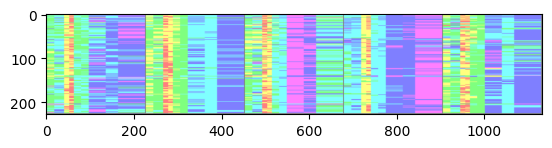

    0     1     0     0     1


In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 130
     Root location: /content/Mydrive/MyDrive/공유EEG/DATA/raw data/raw건강조울/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 33
     Root location: /content/Mydrive/MyDrive/공유EEG/DATA/raw data/raw건강조울/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
            )}

### **1.2 Training**

In [ ]:
save_base_dir = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/raw/'
class_name = 'bipolar_'

In [ ]:
#Step 3_train
train_model_v2(model=model_ft,
            n_epochs=80,
            train_loader=train_loader,
            valid_loader=valid_loader,
            optimizer=optimizer_ft,
            criterion=criterion,
            device=device,
            es=es)


 >> Start Model Training on Epoch:  0
Training Acc:  0.9326923076923077
Training AUC:  0.9790316431566908
Training Loss:  0.19749179669833256
>> Start Model Testing..
Test Acc:  0.6153846153846154
Test AUC:  0.6242424242424243
Test Loss:  1.3921858938313865
Validation loss decreased (-0.894231 --> -0.932692).  Saving model ...
Best Model is Saved at :  /content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/raw/bipolar_weight_test_auc_0.6242424242424243.pt

 >> Start Model Training on Epoch:  1
Training Acc:  0.8269230769230769
Training AUC:  0.9248951582157835
Training Loss:  0.3826574897837071

 >> Start Model Training on Epoch:  2
Training Acc:  0.8461538461538461
Training AUC:  0.9245139153640869
Training Loss:  0.35653112686815713

 >> Start Model Training on Epoch:  3
Training Acc:  0.9615384615384616
Training AUC:  0.9855127716355319
Training Loss:  0.1670242885038966
>> Start Model Testing..
Test Acc:  0.4230769230769231
Test AUC:  0.496969696969697
Test Loss:  1.2548

### **1.3 Evaluation**

In [ ]:
sorted([s for s in os.listdir(save_base_dir) if class_name in s])[-1]

'bipolar_weight_test_auc_0.6848484848484848.pt'

In [ ]:
# load the model

weight_path = sorted([s for s in os.listdir(save_base_dir) if class_name in s])[-1]

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(save_base_dir+weight_path))


# model_inference eval 모드로 꼭 켜주고
model_ft.eval()
print('Import Trained Model!')

Import Trained Model!


In [ ]:
test_preds = list()
test_labels = list()
test_losses = list()
test_preds_prob = list()
for idx, (test_img, test_label) in enumerate(test_loader):

    test_img, test_label = test_img.to(device), test_label.to(device)
    output = model_ft(test_img)
    _, test_pred = torch.max(output, 1)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]
    test_loss = criterion(output, test_label)

    test_losses.append(test_loss.item())
    for i in test_pred:
        test_preds.append(i.item())

    for j in test_label:
        test_labels.append(j.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                                 estimator_name = 'Best test auc')

In [ ]:
from sklearn.metrics import classification_report
# get the best threshold
from numpy import argmax
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (test_preds_prob >= best_thresh).astype(bool)
print(classification_report(test_labels, y_prob_pred, target_names=['Healthy Control', 'Bipolar']))

Best Threshold=0.626477, sensitivity = 0.429, specificity = 1.000, J=0.429
                 precision    recall  f1-score   support

Healthy Control       0.70      1.00      0.83        19
        Bipolar       1.00      0.43      0.60        14

       accuracy                           0.76        33
      macro avg       0.85      0.71      0.71        33
   weighted avg       0.83      0.76      0.73        33



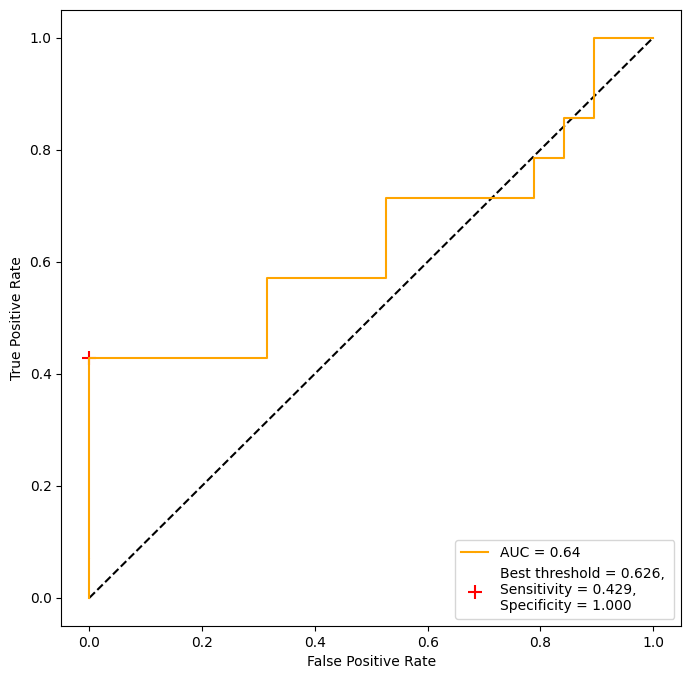

In [ ]:
#plt.figure()plt.figure(facecolor="w")
plt.figure(facecolor="w",figsize=(8,8))
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='orange', markersize=0.05, label="AUC = %.2f" % roc_auc)
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r',
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

## **2. Healthy controls vs. Major depressive disorder**

### **2.1 Data Loading**

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/DATA/cDCGAN_100/raw+gan건강우울'
print('> Label Informations < ')
print(os.listdir(dataset_path))

> Label Informations < 
['val', 'train']


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
}

# train/val(test)일때 각각 transform된 image_datasets 생성
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}

validation_split = .2  # 비율을 얼마로 줄것인지?
shuffle_dataset = True
random_seed= 42

# train, valid 분할을 위한 인덱스 생성
dataset_size = len(image_datasets['train'])
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5, num_workers=2, sampler=train_sampler) #train/test split 후 => train loader 데이터 셋만 이미지 생성 train loader에서 batchsize 설정
valid_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5, num_workers=2, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5, shuffle=False, num_workers=2)

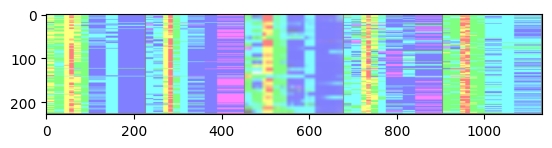

    0     1     1     0     1


In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 434
     Root location: /content/Mydrive/MyDrive/공유EEG/DATA/cDCGAN_100/raw+gan건강우울/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 59
     Root location: /content/Mydrive/MyDrive/공유EEG/DATA/cDCGAN_100/raw+gan건강우울/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
            )}

### **2.2 Training**

In [ ]:
save_base_dir = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/cdcgan100/'
class_name = 'depressive_'

In [ ]:
#Step 3_train
train_model_v2(model=model_ft,
            n_epochs=80,
            train_loader=train_loader,
            valid_loader=valid_loader,
            optimizer=optimizer_ft,
            criterion=criterion,
            device=device,
            es=es)


 >> Start Model Training on Epoch:  0
Training Acc:  0.5862068965517241
Training AUC:  0.8529421939322656
Training Loss:  1.5177949508252953
>> Start Model Testing..
Test Acc:  0.6511627906976745
Test AUC:  0.9307146753955264
Test Loss:  1.2846670399109523
EarlyStopping counter: 1 out of 3
Best Model is Saved at :  /content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/cdcgan100/depressive_weight_test_auc_0.9307146753955264.pt

 >> Start Model Training on Epoch:  1
Training Acc:  0.5919540229885057
Training AUC:  0.8466115473760681
Training Loss:  1.496887689988528

 >> Start Model Training on Epoch:  2
Training Acc:  0.5948275862068966
Training AUC:  0.8365793752378318
Training Loss:  1.583329745874341

 >> Start Model Training on Epoch:  3
Training Acc:  0.5977011494252874
Training AUC:  0.8562977825440204
Training Loss:  1.5371454945100205
>> Start Model Testing..
Test Acc:  0.6976744186046512
Test AUC:  0.9361702127659575
Test Loss:  1.0780255169504218
EarlyStopping coun

### **2.3 Evaluation**

In [ ]:
sorted([s for s in os.listdir(save_base_dir) if class_name in s])[-1]

'depressive_weight_test_auc_0.9361702127659575.pt'

In [ ]:
# load the model
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/depressive_weight_test_auc_0.9361702127659575.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))


# model_inference eval 모드로 꼭 켜주고
model_ft.eval()
print('Import Trained Model!')

Import Trained Model!


In [ ]:
test_preds = list()
test_labels = list()
test_losses = list()
test_preds_prob = list()
for idx, (test_img, test_label) in enumerate(test_loader):

    test_img, test_label = test_img.to(device), test_label.to(device)
    output = model_ft(test_img)
    _, test_pred = torch.max(output, 1)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]
    test_loss = criterion(output, test_label)

    test_losses.append(test_loss.item())
    for i in test_pred:
        test_preds.append(i.item())

    for j in test_label:
        test_labels.append(j.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                                 estimator_name = 'Best test auc')

In [ ]:
from sklearn.metrics import classification_report
# get the best threshold
from numpy import argmax
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (test_preds_prob >= best_thresh).astype(bool)
print(classification_report(test_labels, y_prob_pred, target_names=['Healthy Control', 'depressive']))

Best Threshold=0.131819, sensitivity = 0.800, specificity = 0.579, J=0.379
                 precision    recall  f1-score   support

Healthy Control       0.58      0.58      0.58        19
     depressive       0.80      0.80      0.80        40

       accuracy                           0.73        59
      macro avg       0.69      0.69      0.69        59
   weighted avg       0.73      0.73      0.73        59



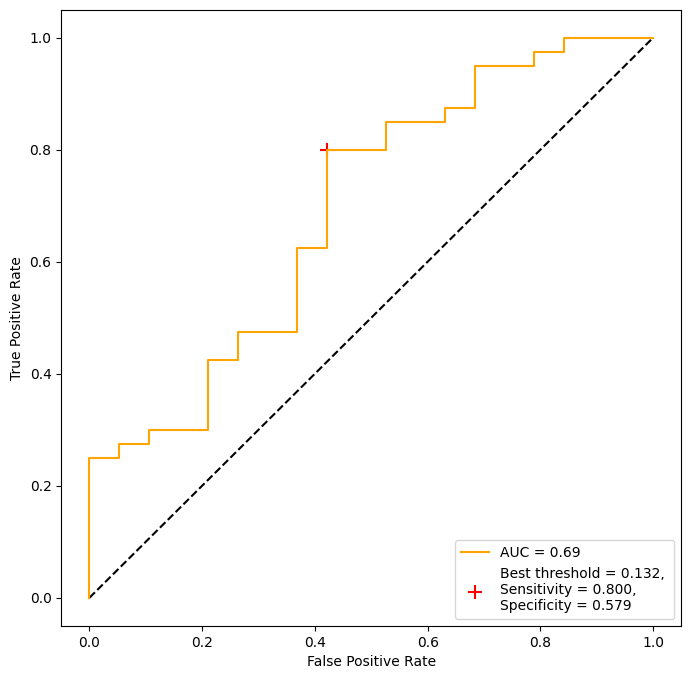

In [ ]:
#plt.figure()plt.figure(facecolor="w")
plt.figure(facecolor="w",figsize=(8,8))
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='orange', markersize=0.05, label="AUC = %.2f" % roc_auc)
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r',
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

In [ ]:
fileset = []
for filename, _ in test_loader.dataset.samples:
  fileset.append(filename.split('/')[-1])

pd.DataFrame({'filename':fileset, 'True':test_labels, 'Predicted':y_prob_pred.astype(int)})

,filename,True,Predicted
0,Detox_HC04.png,0,1
1,Detox_HC05.png,0,1
2,Detox_HC14.png,0,1
3,Detox_HC16.png,0,0
4,Detox_HC17.png,0,0
5,Detox_HC33.png,0,0
6,HC01.png,0,0
7,HC02.png,0,0
8,HC03.png,0,0
9,HC05.png,0,1


## **3. Healthy controls vs. Schizophrenia**

### **3.1 Data Loading**

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/DATA/cDCGAN_100/raw+gan건강조현'
print('> Label Informations < ')
print(os.listdir(dataset_path))

> Label Informations < 
['val', 'train']


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))

    ]),
}

# train/val(test)일때 각각 transform된 image_datasets 생성
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}

validation_split = .2  # 비율을 얼마로 줄것인지?
shuffle_dataset = True
random_seed= 42

# train, valid 분할을 위한 인덱스 생성
dataset_size = len(image_datasets['train'])
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5, num_workers=2, sampler=train_sampler) #train/test split 후 => train loader 데이터 셋만 이미지 생성 train loader에서 batchsize 설정
valid_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5, num_workers=2, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5, shuffle=False, num_workers=2)

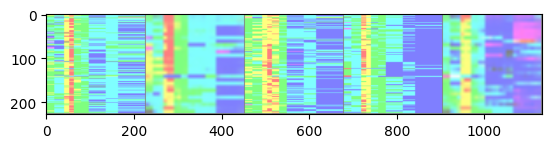

    1     1     1     1     0


In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 368
     Root location: /content/Mydrive/MyDrive/공유EEG/DATA/cDCGAN_100/raw+gan건강조현/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 43
     Root location: /content/Mydrive/MyDrive/공유EEG/DATA/cDCGAN_100/raw+gan건강조현/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
            )}

### **3.2 Training**

In [ ]:
save_base_dir = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/cdcgan100/'
class_name = 'Schizophrenia_'

In [ ]:
#Step 3_train
train_model_v2(model=model_ft,
            n_epochs=80,
            train_loader=train_loader,
            valid_loader=valid_loader,
            optimizer=optimizer_ft,
            criterion=criterion,
            device=device,
            es=es)


 >> Start Model Training on Epoch:  0
Training Acc:  0.6847457627118644
Training AUC:  0.7156980504481197
Training Loss:  0.7251447237144082
>> Start Model Testing..
Test Acc:  0.8082191780821918
Test AUC:  0.8846153846153846
Test Loss:  0.8146609862645467
Validation loss decreased (inf --> -0.684746).  Saving model ...
Best Model is Saved at :  /content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/cdcgan100/Schizophrenia_weight_test_auc_0.8846153846153846.pt

 >> Start Model Training on Epoch:  1
Training Acc:  0.7728813559322034
Training AUC:  0.8113277279866951
Training Loss:  0.5672583287045107

 >> Start Model Training on Epoch:  2
Training Acc:  0.8169491525423729
Training AUC:  0.8646401182666543
Training Loss:  0.46071952833967694

 >> Start Model Training on Epoch:  3
Training Acc:  0.8440677966101695
Training AUC:  0.8998891250115495
Training Loss:  0.3965108678123708
>> Start Model Testing..
Test Acc:  0.8082191780821918
Test AUC:  0.9577677224736049
Test Loss:  

### **3.3 Evaluation**

In [ ]:
sorted([s for s in os.listdir(save_base_dir) if class_name in s])[-1]

'Schizophrenia_weight_test_auc_0.9592760180995475.pt'

In [ ]:
# load the model
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/Schizophrenia_weight_test_auc_0.9592760180995475.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))


# model_inference eval 모드로 꼭 켜주고
model_ft.eval()
print('Import Trained Model!')

Import Trained Model!


In [ ]:
test_preds = list()
test_labels = list()
test_losses = list()
test_preds_prob = list()
for idx, (test_img, test_label) in enumerate(test_loader):

    test_img, test_label = test_img.to(device), test_label.to(device)
    output = model_ft(test_img)
    _, test_pred = torch.max(output, 1)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]
    test_loss = criterion(output, test_label)

    test_losses.append(test_loss.item())
    for i in test_pred:
        test_preds.append(i.item())

    for j in test_label:
        test_labels.append(j.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                                 estimator_name = 'Best test auc')

In [ ]:
from sklearn.metrics import classification_report
# get the best threshold
from numpy import argmax
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (test_preds_prob >= best_thresh).astype(bool)
print(classification_report(test_labels, y_prob_pred, target_names=['Healthy Control', 'Schizophrenia']))

Best Threshold=0.566446, sensitivity = 0.917, specificity = 0.789, J=0.706
                 precision    recall  f1-score   support

Healthy Control       0.88      0.79      0.83        19
  Schizophrenia       0.85      0.92      0.88        24

       accuracy                           0.86        43
      macro avg       0.86      0.85      0.86        43
   weighted avg       0.86      0.86      0.86        43



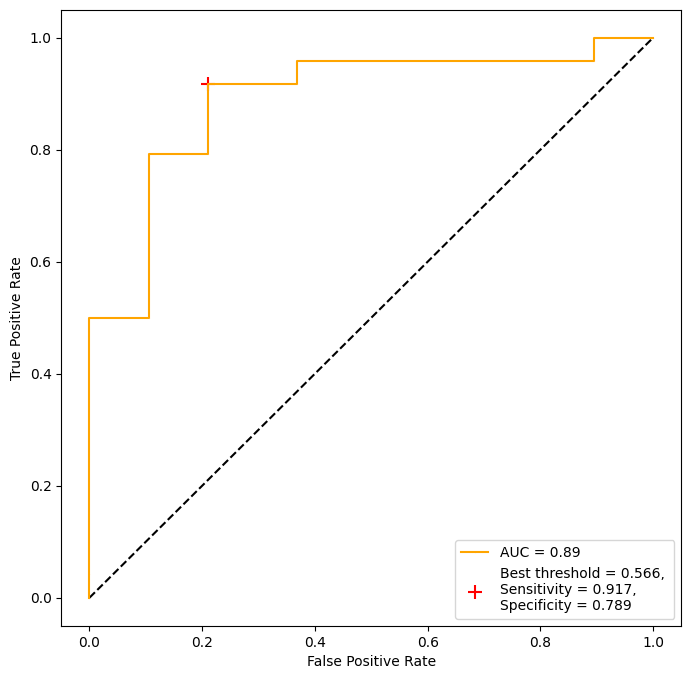

In [ ]:
#plt.figure()plt.figure(facecolor="w")
plt.figure(facecolor="w",figsize=(8,8))
#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='orange', markersize=0.05, label="AUC = %.2f" % roc_auc)
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r',
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

In [ ]:
fileset = []
for filename, _ in test_loader.dataset.samples:
  fileset.append(filename.split('/')[-1])

pd.DataFrame({'filename':fileset, 'True':test_labels, 'Predicted':y_prob_pred.astype(int)})

,filename,True,Predicted
0,Detox_HC04.png,0,1
1,Detox_HC05.png,0,0
2,Detox_HC14.png,0,0
3,Detox_HC16.png,0,0
4,Detox_HC17.png,0,1
5,Detox_HC33.png,0,0
6,HC01.png,0,0
7,HC02.png,0,0
8,HC03.png,0,1
9,HC05.png,0,1
